# Perceptron, Adaline, and Optimization

In [1]:
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

# Outline about this lecture
* In this Lecture, we will guide you through the implementation of Perceptron and Adaline, two of the first algorithmically described machine learning algorithms for the classification problem. 
* We will also discuss how to train these models using the optimization techniques, including the gradient descent (GD) and stochastic gradient descent (SGD), and compare their convergence speed.

# Data Preparation
* We use the [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset from the UCI machine learning repository
* It consists of 150 iris plants as examples, each with the sepal and petal sizes as attributes and the type as class label.
* Download the Iris dataset using [Pandas](http://pandas.pydata.org/) first:

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split

# Read the dataset from website
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# Split the dataset to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print('#Training data points: {}'.format(X_train.shape[0]))
print('#Testing data points: {}'.format(X_test.shape[0]))
print('Class labels: {} (mapped from {}'.format(np.unique(y), np.unique(df['Class label'])))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 100
#Testing data points: 50
Class labels: [0 1 2] (mapped from ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


# <a name='BackGD'>Standardization for Gradient Descent</a>
* More information about [Gradient Descent](#GD)
* Recall from the lecture that the gradient descent may perform poorly if the [Hessian of the function](#Hessian) $f$ to be minimized has a large condition number.
* In this case, the surface of $f$ can be curvy in some directions but flat in the others.
* Therefore, the gradient descent, which ignores the curvatures, may [overshoot](#overshoot) the optimal point along curvy directions but take too small step along flat ones.
* One common way to improve the conditioning of f is to standardize its parameter X , as follows:

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

* $\color{red}{\text{Note:}}$
    * The standardization should calculate the mean $\mu$ and variance $\sigma^{2}$ using only the training set, as the testing set must be remain unknown during the entire training process.

# <a name='perceptron'>Training Perceptron via Scikit-learn</a>
* More information [Perception](#P)
* Having standardized the training data, we can now train a Perceptron model:

In [4]:
from sklearn.linear_model import Perceptron

# max_iter : The maximum number of passes over the training data
# eta0 : learning rate
ppn = Perceptron(max_iter=10, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

/home/epl002/DL/env-name/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
      fit_intercept=True, max_iter=10, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)

* Having trained a model in Scikit-learn, we can make predictions over the testing set and report the accuracy. 
* Note that the testing set should be standardized in the exact same way as the training set.

In [5]:
from sklearn.metrics import accuracy_score

y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 5
Accuracy: 0.90


*  Let's plot the decision boundaries to see how the model works:

In [6]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set', edgecolors='k')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


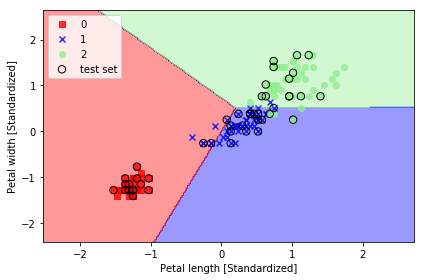

In [7]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('./output/fig-perceptron-scikit.png', dpi=300)
plt.show()

# <a name='MC'>Multiclass Classification</a>
* The Perceptron model is originally designed for the **binary classification** problems.
* We can see from the above that the model implemented in the Scikit-learn is able to predict the labels of multiple classes (3 in this case). 
* This is achieved by wrapping the binary model with an [One-vs-All](#OvA) (or [One-vs-Rest](https://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest)) procedure.
*  If there are K classes, then this procedure trains K binary classifiers for each class, where each classifier treats only one class as positive and the rests as negative.
* To predict the label of a testing data point, each classifier generates the soft output $f(\boldsymbol{x}) = \boldsymbol{w}^{\top}\boldsymbol{x}-b\in{\mathbb{R}}$ for every class, and then the class who gets the highest output value becomes the predicted label.

# Implementing Perceptron
* We only implement the binary Perceptron model. 

In [8]:
import numpy as np

class Perceptron2(object):
    """Perceptron classifier.
    
    Parameters
    ------------
    eta: float 
        Learning rate (between 0.0 and 1.0)
    n_iter: int
        Number of epochs, i.e., passes over the training dataset.
        
    Attributes
    ------------
    w_: 1d-array
        Weights after fitting.
    errors_: list
        Number of misclassifications in every epoch.
    random_state : int
        The seed of the pseudo random number generator.
    """
    
    def __init__(self, eta=0.01, n_iter=10, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0.0
            for xi, target in zip(X, y):
                update = self.eta * (self.predict(xi) - target)
                self.w_[1:] -= update * xi
                self.w_[0] -= update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

* $\color{red}{\text{Note:}}$
    1. We could have implemented the shorthand version of $X$ and $w$ to include the bias term. However, we single out the addition of the bias term (self.w_[0]) for performance reason, as adding a vector of 1's to the training array each time we want to make a prediction would be inefficient.
    2. Some production implementation shuffles data in the beginning of each epoch. We omit this step for simplicity.

* To train our binary Perceptron model using the Iris dataset, we recreate our training and testing sets so that they contain only binary labels:

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

#Training data points: 90
#Testing data points: 10
Class labels: [-1  1]


* Train our model:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Misclassified samples: 3
Accuracy: 0.70


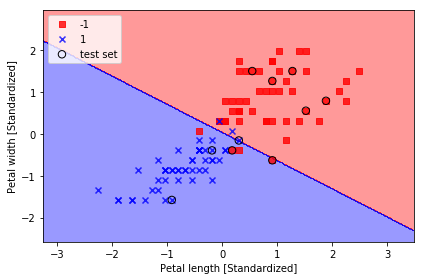

In [10]:
# training

ppn2 = Perceptron2(eta=0.1, n_iter=20)

ppn2.fit(X_train_std, y_train)

# testing

y_pred = ppn2.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot descision boundary

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined, 
                      classifier=ppn2, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-perceptron2-boundary.png', dpi=300)
plt.show()

* This is mainly because the training algorithm does not converge when the data points are **not linearly separable** (by a hyperplane).
* We can track convergence using the **errors_** attributes:

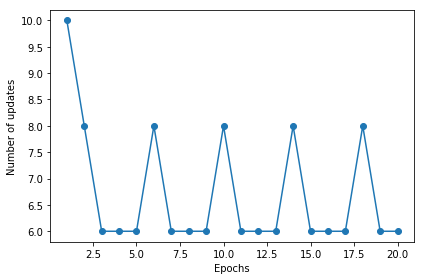

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

plt.tight_layout()
plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()

* As we can see, the weights never stop updating. To terminate the training process, we have to set a maximum number of epochs.

# <a name='ImplementAGD'>Implementing Adaline with GD</a>
* [The ADAptive LInear NEuron (Adaline)](#AGD) is similar to the Perceptron, except that it defines a cost function based on the soft output and an optimization problem. 
* We can therefore leverage various optimization techniques to train Adaline in a more theoretic grounded manner.
* Let's implement the Adaline using the batch gradient descent (GD) algorithm:

In [12]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            #與Percrptron的差別
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

* As discussed in the lecture, a good learning rate $η$ is a key to the optimal convergence.
* Let's plot the cost against the number of epochs for the two different learning rates:

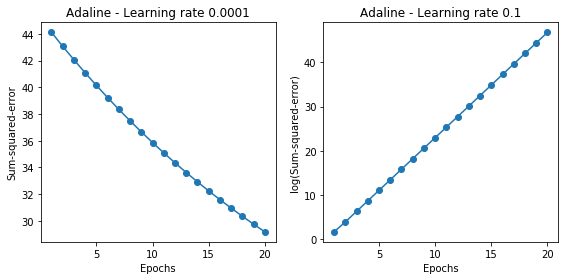

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=20, eta=0.0001).fit(X_train_std, y_train)
ax[0].plot(range(1, len(ada1.cost_) + 1), ada1.cost_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Sum-squared-error')
ax[0].set_title('Adaline - Learning rate 0.0001')

ada2 = AdalineGD(n_iter=20, eta=0.1).fit(X_train_std, y_train)
ax[1].plot(range(1, len(ada2.cost_) + 1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.1')

plt.tight_layout()
plt.savefig('./output/fig-adaline-gd-overshoot.png', dpi=300)
plt.show()

* The left figure shows what could happen if we choose a too small learning rate: although the cost decreases, the descent is too small that the algorithm would require a **large number of epochs** to converge.
* The right figure shows what could happen if we choose a learning rate that is too large: instead of minimizing the cost function, the error becomes larger in every epoch because we **[overshoot](#overshoot)** the optimal point every time.
<img src='https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/fig-overshoot.png' width='500'></img>
* With a properly chosen learning rate $η$ , the AdalineGD converges and gives a better prediction accuracy (80%) as compared with the Perceptron (70%):

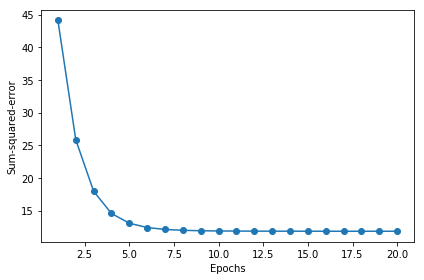

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Misclassified samples: 2
Accuracy: 0.80


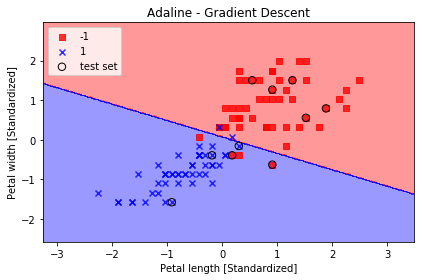

In [14]:
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision boundary 

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=ada, test_idx=range(len(y_train),
                                                    len(y_train) + len(y_test)))
plt.title('Adaline - Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-gd-boundary.png', dpi=300)
plt.show()

# <a name='BackSGD'>Implementing Adaline with SGD</a>
* More information about [SGD](#SGD)
* The stochastic gradient descent (SGD) update the weights incrementally for each minibatch of size $M$, $M≪N$.
    * 每次更新只考慮一個樣本的數據誤差，所以速度很快，能進行online的參數更新
* SGD usually reaches convergence much faster because of the more frequent weight updates. Since each gradient is calculated based on few training examples, the point taken at each step may "wander" randomly and the cost value may not always decrease.
* However, this may be considered as an advantage in that it can escape shallow local minima when the cost function is not convex. To prevent SGD from wandering around the optimal point, we often replace the constant learning rate $\eta$ by an adaptive learning rate that decreases over time.
* For example, we can let $$\eta=\frac{a}{t+b},$$where t is the iteration number and a and b are constants.
* Furthermore, to hold the assumption that each minibatch consists of "randomly sampled" points from the same data generation distribution when we regard the cost function as an expectation, it is important to feed SGD with data in a random order, which is why we **shuffle the training set** for every epoch.
* Implement the Adaline with SGD. For simplicity, we use a constant learning rate and set M=1

In [15]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

* We pass **random_state** to **np.random.seed** so it will be used for shuffling and initializing the weights.
* If we modify the **activation()** method so that it is identical to the **predict()** method, then this class degenerates into the Perceptron with shuffling.

* $\color{red}{\text{Note:}}$
    * Although not shown in our implementation, setting a larger minibatch size M>1 is advantages on modern CPU architecture as we can replace the for-loop over the training samples by vectorized operations, which is usually improve the computational efficiency.
    * Vectorization means that an elemental arithmetic operation is automatically applied to all elements in an array.
    * By formulating our arithmetic operations as a sequence of instructions on an array rather than performing a set of operations for each element one at a time, we can make better use of our modern CPU architectures with Single Instruction, Multiple Data (SIMD) support.
    * Furthermore, many scientific libraries like NumPy use highly optimized linear algebra libraries, such as Basic Linear Algebra Subprograms (BLAS) and Linear Algebra Package (LAPACK) that implement vectorized operations in C or Fortran.

* Let's see how Adaline performs with SGD:

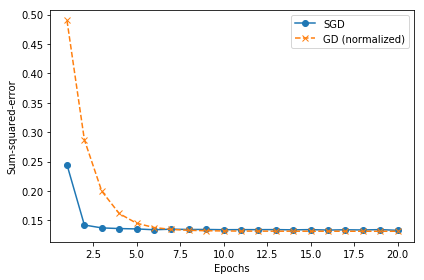

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Misclassified samples: 2
Accuracy: 0.80


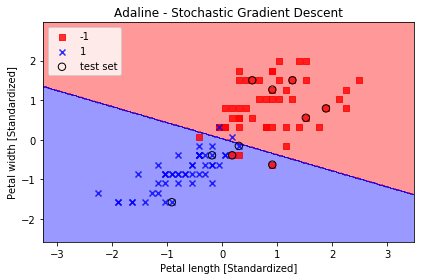

In [16]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD')
plt.plot(range(1, len(ada.cost_) + 1), np.array(ada.cost_) / len(y_train), 
         marker='x', linestyle='--', label='GD (normalized)')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision boundary 

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-boundary.png', dpi=300)
plt.show()

* As we can see, the cost value goes down pretty quickly, and is only sightly worse than the (normalized) cost value of the batch gradient descent after 7 epochs.

* Another advantage of stochastic gradient descent is that we can use it for online learning.
* In online learning, a model is trained on-the-fly as new training data arrives.This is especially useful if we are accumulating large amounts of data over time.
* For example, customer data in typical web applications. Using online learning, the system can immediately adapt to changes without training from the scratch. Furthermore, if storage space is an issue, we can discard the training data after updating the model. In our implementation, we provide the **partial_fit()** method for online learning.

# Assignment
* Implement the Adaline with SGD which can set different batch_size ($M$) as parameter.Then, use the Iris dataset to fit your model with 3 different $M$ (including $M$=1) and fixed learning rate $η$ and print out the accuracy of each model. Last, plot the cost against the number of epochs using different $M$ in one figure.

### $\color{red}{\text{Note:}}$
1. To simplfy your work, you can ignore part of data which is not divisible by M.

### Your code file should contain:
1. Split training and testing data (test_size = 20% of the whole dataset)
2. Handcrafted Adaline classifier with $M$ as parameter.
3. Fit model with 3 different $M$ and fixed $η$. (including $M$=1)
4. Print the accuracy of each model.
5. Plot the cost against the number of epochs using different M in one figure.

### Your image file should contain:
1. Figure of the cost against the number of epochs using different $M$.

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## First step:
* Dataset need to preprocess

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

SGD_sc = StandardScaler()
SGD_sc.fit(X_train)
X_train_std = SGD_sc.transform(X_train)
X_test_std = SGD_sc.transform(X_test)

## Second step:
* Chage the batch size
* $\color{red}{\text{Hint:}}$
    * Be care of the shape, when the _update_weights need to plus two matrix
    * Notice that the length have been already changed

In [19]:
from numpy.random import seed

class AdalineMSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y, batch_size):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.M = int(X.shape[0]/batch_size)
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            """code"""
            for j in range(self.M):
                xi = X[batch_size*j : batch_size*(j+1)]
                target = y[batch_size*j : batch_size*(j+1)]
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / self.M
            self.cost_.append(avg_cost.sum())
            """code"""
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        error = (target - output)
        self.w_[1:] += self.eta * error.T.dot(xi)
        self.w_[0] += self.eta * error.sum()
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

## Third steps:
* Just print the line in one picture
* Remeber to print the accuracy

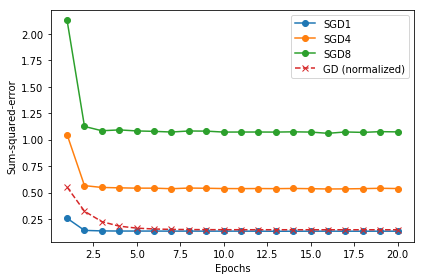

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

M = 1
Misclassified samples: 3
Accuracy: 0.85
M = 4
Misclassified samples: 3
Accuracy: 0.85
M = 8
Misclassified samples: 3
Accuracy: 0.85


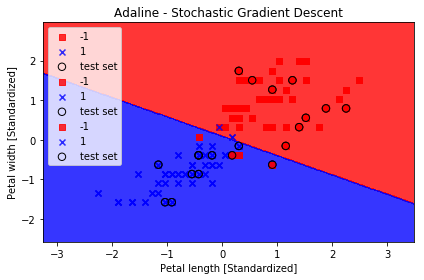

In [20]:
adas1 = AdalineMSGD(n_iter=20, eta=0.01, random_state=1)
adas1.fit(X_train_std, y_train, 1)

# cost values
plt.plot(range(1, len(adas1.cost_) + 1), adas1.cost_, 
         marker='o', label='SGD1')

"""code"""
adas4 = AdalineMSGD(n_iter=20, eta=0.01, random_state=1)
adas4.fit(X_train_std, y_train, 4)

plt.plot(range(1, len(adas4.cost_) + 1), adas4.cost_, 
         marker='o', label='SGD4')

adas8 = AdalineMSGD(n_iter=20, eta=0.01, random_state=1)
adas8.fit(X_train_std, y_train, 8)
"""code end"""

plt.plot(range(1, len(adas8.cost_) + 1), adas8.cost_, 
         marker='o', label='SGD8')


plt.plot(range(1, len(ada.cost_) + 1), np.array(ada.cost_) / len(y_train), 
         marker='x', linestyle='--', label='GD (normalized)')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = adas1.predict(X_test_std)
print('M = 1')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

y_pred = adas4.predict(X_test_std)
print('M = 4')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

y_pred = adas8.predict(X_test_std)
print('M = 8')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision boundary 

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas1, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
"""code"""
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas4, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas8, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
"""code end"""
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-boundary.png', dpi=300)
plt.show()

# <a name='GD'>Gradient Descent</a>
* Gradient Descent 就好比『我們在山頂，但不知道要下山的路，於是，我們就沿路找向下坡度最大的叉路走，直到下到平地為止』
* 要找到向下坡度最大，在數學上常使用『偏微分』(Partial Differential)，求取斜率，一步步的逼近，直到沒有顯著改善為止，這時我們就認為是最佳解了
<img src='https://ithelp.ithome.com.tw/upload/images/20171203/20001976tHmwPv6YYG.png' width='600'></img>
* 我們先建構好模型，決定要做幾層的隱藏層，接著，Neural Network 就會利用 Forward Propagation 及 Backpropagation 機制，幫我們求算模型中最重要的參數『權重』(Weight)，這個過程就稱為『最佳化』(Optimization)，最常用的技巧就是『梯度下降』(Gradient Descent)。
<img src='https://ithelp.ithome.com.tw/upload/images/20180326/20001976ZvQ1jpvvYJ.png' width='400'></img>
## For example:
<img src='https://ithelp.ithome.com.tw/upload/images/20180326/20001976gHukZnu4sd.png' width='400'></img> 
    1. 先任意假設一組權重(W)，如圖中紅圈內數字
    2. 每一層的 output 就等於 前一層的 input 乘以權重(W)， 即 y = sum(w * x)，這個過程就是 Forward Propagation
        * ex: 隱藏層的第一個節點(Node)就等於 2 * 1 + 3 * 1 = 5
        * ex: 第二個節點就等於 2 * -1 + 3 * 1 = 1
        * ex: output層就等於 5 * 2 + 1 * -1 = 9
    3. 接著，我們就反推回去(Backpropagation)，用『梯度下降法』，逐步調整權重(W)，慢慢逼近最佳解，以達到『損失函數最小化』
    <img src='https://ithelp.ithome.com.tw/upload/images/20180326/20001976hXyCazmg7X.png' width='400'></img> 
       先求算梯度(Gradient)，再依梯度往下走，損失就會越來越小。
       * ex: 假設已知資料的ouput實際值為 13，那損失就等於 13-9 = 4，這時的output對隱藏層兩個節點的梯度就分別等於 -2 * 5 * 4 = -40 及 -2 * 1 * 4 = -8，因此，就可以設定下降的步幅，即學習率(Learning Rate)，譬如 0.01，所以，調整新權重 = 原權重 - (學習率 * 梯度)，推算出所有的權重後，再回到步驟2，不斷循環，直到損失的縮小已經不顯著了，就認定那一組權重是最佳解。

## 梯度數學證明
* 梯度可以使用<a name='OLS'>『最小平方估計法』(Ordinary Least Sequare, OLS)</a>求得，利用偏微分求『梯度』
<img src='https://ithelp.ithome.com.tw/upload/images/20180326/20001976Ke8R0DCxRw.png' width='400'></img>
* 如果有 bias：即 y = b + w * x，只要等式兩邊各減 b，變成 y' = w * x，還是可以用上圖推導，公式不變。
* 會看到 SSE 會乘上 ½，書上說是為了計算方便。
* [Reference](https://ithelp.ithome.com.tw/articles/10198147)
* [Go back to Standardization for Gradient Descent](#BackGD)

# <a name='Hessian'>Hessian function</a>
* 黑塞矩陣（Hessian Matrix），又譯作海森矩陣、海瑟矩陣、海塞矩陣等
* 最早於19世紀由德國數學家Ludwig Otto Hesse提出，並以其名字命名，常用於牛頓法解決優化問題
* 一個多元函式的二階偏導數構成的方陣，描述了函式的區域性曲率
* 在machine learing裡，可以考慮採用它來計算n值比較少的資料，在影象處理裡，可以抽取影象特徵，在金融裡可以用來作量化分析
* 一個函數的二次微分（ Hessian Matrix ）
    * 一次微分（函數的梯度）：函數對向量微分，得到向量
    * 二次微分（函數的梯度的梯度）：再次對向量微分，得到矩陣
    * 該矩陣是「一個函數的二階導數矩陣」，一定是對稱矩陣，稱作 Hessian Matrix 。
$$f^{'}=\frac{\partial {f}}{\partial {x}}=\begin{bmatrix} \frac{\partial {f}}{\partial {x_{0}}} \\ \frac{\partial {f}}{\partial {x_{1}}} \\ \frac{\partial {f}}{\partial {x_{2}}} \\ \end{bmatrix}$$
$$f^{''}=\frac{\partial {f^{'}}}{\partial {x}}= H =
\begin{bmatrix} 
\frac{\partial^{2} {f}}{\partial {x_{0}}\partial {x_{0}}} & \frac{\partial^{2} {f}}{\partial {x_{1}}\partial {x_{0}}} & \frac{\partial^{2} {f}}{\partial {x_{2}}\partial {x_{0}}} \\ 
\frac{\partial^{2} {f}}{\partial {x_{0}}\partial {x_{1}}} & \frac{\partial^{2} {f}}{\partial {x_{1}}\partial {x_{1}}} & \frac{\partial^{2} {f}}{\partial {x_{2}}\partial {x_{1}}} \\ 
\frac{\partial^{2} {f}}{\partial {x_{0}}\partial {x_{2}}} & \frac{\partial^{2} {f}}{\partial {x_{1}}\partial {x_{2}}} & \frac{\partial^{2} {f}}{\partial {x_{2}}\partial {x_{2}}} \\ 
\end{bmatrix}$$
* 二次微分＝原函數的 Hessian Matrix ＝一階導數的 Transpose Jacobian Matrix，由於是對稱矩陣，可以省略轉置。
$$f^{''}=H_{f}=J_{f^{'^{T}}}=J_{f^{'}}$$
* [Reference1](https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/574589/)
* [Reference2](http://www.csie.ntnu.edu.tw/~u91029/MultivariateFunction.html)
* [Go back to Standardization for Gradient Descent](#BackGD)

# <a name='OvA'>One-vs.-rest</a>
* 策略需要為每一個類建立一個唯一的分類器
* 做法是將除了目前處理的類別之外的類別都視為同個群體，根據最大的機率來分類出其最有可能的圖形
* [Reference](https://medium.com/@ken90242/machine-learning%E5%AD%B8%E7%BF%92%E6%97%A5%E8%A8%98-coursera%E7%AF%87-week-3-3-multiclass-classification-one-vs-all-8f8d48a57ae9)
* [Go back to Multiclass Classification](#MC)

# <a name='P'>Perceptron</a>
* Perceptron（也稱為Perceptron Learning Algorithm簡稱PLA
* 感知器是以生物的“神經元模型”為基礎所開發出來的演算法，但其實只是概念類似跟真實的生物神經元傳遞訊號的機制類似
* 注意Perceptron這個演算法只有在資料是線性可分的形況下才能正確
    * 什麼是資料是線性可分呢？以2D的情況簡單來說就是可以在平面上找一條線去完全切出這兩群，3D的話就是可以在空間中找一個平面去切出兩群
    <img src='https://cdn-images-1.medium.com/max/800/1*HAmYr3Prou-kZ-38OZf-Uw.png' width='450'></img>
* 左邊的突觸是神經接收訊息的地方(input)，若input的訊號總和強度大於等於某一個值(threshold)，這個神經元就會透過軸突(axon)發送訊息到右邊的突觸給下一個神經元
<img src='https://cdn-images-1.medium.com/max/800/1*J0zzv7JjJOUh6ycSOVfl3Q.png' width='300'></img>
    * 假設左邊的突觸有n個，每一個input以 $x1, x2, x3,…xn$來表示的話，當 $w1*x1 + w2*x2 + w3*x3 +…. wn*xn$ >某一個定值，就會出發神經元發送信號出去。
    * w1,w2,…wn,以及某一個定值都是這個神經元根據過往經驗學會的數字，也是資料科學家平常說在train這個model到底是在train什麼，就是找出w1,w2…wn以及某一個定值。
    * 為了往後計算方便，會把“某一個定值”移到等號左邊當成w0(w0 = 某一個定值的負號, x0 則永遠都是1)，變成x0*w0＋x1*w1+x2*w2+…+xn*wn >0
    * 二元分類來說（+1代表1類, -1但表另一類），只要這些數字大於0就判斷是+1,小於等於零就是-1(也可以定成大於等於0就是+1小於零就是-1) 
    <img src='https://cdn-images-1.medium.com/max/800/1*MofmXIxbv5AOIXHQp_hSOw.png' width='450'></img>
    * 上圖中的Activation function(激勵函數)，就是大於0就判斷1、小於等於0就判斷成是-1

* Perception優點：
    1. 最簡單的線性分類演算法，Perception演算法的原理可推廣至其他複雜的演算法，因此許多課程或是書籍皆會以此當作最初的教材。
* Perception缺點：
    1. 一定要線性可分Perception演算法才會停下來（實務上我們沒辦法事先知道資料是否線性可分）
    2. Perception演算法的錯誤率不會逐步收斂
    3. Perception演算法只知道結果是A類還B類，但沒辦法知道是A, B類的機率是多少（Logistic regression可解決此問題）
* [Reference](https://medium.com/@yehjames/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC3-2%E8%AC%9B-%E7%B7%9A%E6%80%A7%E5%88%86%E9%A1%9E-%E6%84%9F%E7%9F%A5%E5%99%A8-perceptron-%E4%BB%8B%E7%B4%B9-84d8b809f866)
* [Go back to Training Perceptron via Scikit-learn](#perceptron)

# <a name='AGD'>Adaptive Linear Neuron -- Adaline</a>
* An implementation of the ADAptive LInear NEuron, Adaline, for **binary classification tasks**
<img src='http://rasbt.github.io/mlxtend/user_guide/classifier/Adaline_files/adaline_schematic.png' width='400'></img>
* The Adaline classifier is closely related to the [Ordinary Least Squares](#OLS) (OLS) Linear Regression algorithm; in OLS regression we find the line (or hyperplane) that minimizes the vertical offsets. In other words, we define the best-fitting line as the line that minimizes the sum of squared errors (SSE) or mean squared error (MSE) between our target variable (y) and our predicted output over all samples i in our dataset of size $n$.
$$SSE=\sum_{i}(target^{(i)}-output{(i)})^{2}$$
$$ MSE = \frac{1}{n}\times SSE$$
* Add a threshold function g(⋅) to convert the continuous outcome to a categorical class label
$$y = g({z}) = \begin{cases} 1, & \text {if z ≥ 0} \\ -1, & \text{otherwise.} \end{cases} $$
* An Adaline model can be trained by one of the following three approaches:
    1. Normal Equations
    2. Gradient Descent
    3. Stochastic Gradient Descent
* Perceptron v.s. Adaline
    * 根本區別在於對weight的更新方法不同
    * Adaline
    <img src='https://upload-images.jianshu.io/upload_images/6035053-634b0d18ed8ee586.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/639/format/webp' width='400'></img>
    * Perceptron
    <img src='https://upload-images.jianshu.io/upload_images/6035053-510f36e9e6e73f39.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/575/format/webp' width='400'></img>
    * Adaline比Perceptron多了一個量化器，用於將Activation function輸出的結果進行二分，來判斷樣本的類別
* [Reference](http://rasbt.github.io/mlxtend/user_guide/classifier/Adaline/)
* [Go back to Implementing Adaline with GD](#ImplementAGD)

# <a name='SGD'>SGD</a>
* Adaline最大的缺點是需要全部的x, y來計算出weight，但用在大數據的情況下是不太可能的
* SGD就是一種特殊批量處理的梯度下降算法，會隨機選擇sample $x^{i}$來更新weights，特殊的原因是他的batch_size=1，也就是一個batch一個batch處理
* adaptive learning rate是在SGD裡常用到的**可變換learning rate**，例如:
    * $η=\frac{C_{1}}{n_iter+C_{2}}$
* 缺點:
    * 找到適合的learning rate較為困難，
    * 容易收斂到局部最優
* Mini-Batch Gradient Descent (MB-GD)則是更為廣義的批量處理，例如:batch_size=50
* [Reference](https://blog.csdn.net/hallao0/article/details/74910579)
* Go back to [Implementing Adaline with SGD](#BackSGD)

# <a name='overshoot'>Overshoot</a>
<img src='https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/fig-overshoot.png' width='550'></img>
* 簡單講就是當learning rate太大時，會發生找不到適合的weight，如右圖，weight的數值反而會更糟糕，loss不降反升
* [Go back to Standardization for Gradient Descent](#BackGD)